<img src="Project Description.PNG" alt="Drawing" style="width: 800px;"/>

In [1]:
%pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import random
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


size = 18
params = {'legend.fontsize': 'large',
          'figure.figsize': (15,8),
          'axes.labelsize': size * 0.8,
          'axes.titlesize': size * 0.95,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}

plt.rcParams.update(params)

In [260]:
class DataReader:
    
    def __init__(self):
        pass
    
    def GetStockData(self):
        
        price = yf.download("^STOXX50E", start = "2019-12-01", end = "2020-12-3")['Adj Close'].reset_index()
        plt.plot(price['Date'], price['Adj Close'], label = "STOXX50E")
        plt.legend()
        plt.show()

        return price
    
    def GetLiborData(self):
        
        libor = pd.read_csv('3-month-libor.csv').fillna(method = 'bfill').fillna(method = 'ffill')

        libor['Date'] = libor['Date'].astype('datetime64[ns]')
        libor = libor.sort_values(by = ['Date'])
        libor = libor.iloc[-252:]

        plt.title("historical LIBOR")
        plt.plot(libor['Date'], libor['3M'])
        plt.show()
        
        return libor

datareader = DataReader()

In [272]:
class Models():
    
    def __init__(self):
        pass
    
    
    def MleVasicek(self, df):
        
        '''
        Using Maximum Likelihood to estimate the parameters of Vasicek Model
        '''
        
        r = np.array(df['3M'])
        a = r[:len(r)-1]
        r = r[1:]

        x = np.array(df['3M'])
        b = x[:len(x)-1]

        s0 = (np.sum(r) - r[-1]) / len(r)
        s1 = np.mean(r)
        s00 = np.sum(a**2) / len(r)
        s01 = np.sum(b*r) / len(r)

        rn = (s1*s00 - s0*s01) / ((s0*s1) - (s0**2) + (s00-s01))
        k = np.log((s0-np.mean(x)) / (s1 - np.mean(x)) ) / 1
        beta = 1/k * (1 - np.exp(k))

        def B(s):
            return (1 - np.exp(-k))/k

        u = np.mean(x)
        m = np.array([])

        for i in range(1,len(x)):
            g = (u * k * B(k)) + (x[i-1] * (1- (k * B(k)))) 
            m = np.append(m,g)

        sig = 1/((len(x)*beta)*(1 - k*beta/2)) * np.sum((r - m)**2)

        return rn,k,beta,sig
    
    def Vasicek(self,df, r0, K, theta, sigma, T=1., N=252, seed=777):    
    
        np.random.seed(seed)
        dt = T/float(N)    
        rates = [r0]
        for i in range(N):
            dr = K*(theta-rates[-1])*dt + sigma*np.random.normal()
            rates.append(rates[-1] + dr)
        
        rng = pd.date_range(df['Date'].iloc[-1], periods=253 , freq='B')
        lib = pd.DataFrame({ 'Date': rng, '3M': rates}) 

        return lib

    def MleGBM(self, price):
        
        '''
        Using Maximum Likelihood to estimate the parameters of GBM Model
        '''
        
        n = len(price['Date'])
        delta = 1
        x_bar = np.sum(np.log(price['Adj Close']/price['Adj Close'].shift(1)))/n

        print ("MLE for Drift parameter(μ) : " + str(x_bar))
        
        price_bar = np.log(price['Adj Close']/price['Adj Close'].shift(1)) - x_bar
        vol = np.sum(np.power(price_bar, 2))/n
        vol = np.sqrt(vol)
        print ("MLE for Volatility parameter(σ) : " + str(vol))
        
        return x_bar, vol
    
    def Brownian(self, seed, N):
    
        np.random.seed(seed)                         
        dt = 1                                    # time step
        b = np.random.normal(0., 1., int(N))*np.sqrt(dt)  # brownian increments
        W = np.cumsum(b)                             # brownian path
        return W, b

    def GBM(self, seed, price, x_bar, vol): 

        def Simulate(So, mu, sigma, W, T, N):    
            t = np.ones((N + 1))
            S = []
            S.append(So)
            for i in range(1,int(N+1)):

                #drift = (mu - 0.5 * sigma**2) * t[i]
                drift = (mu) * t[i]
                diffusion = sigma * W[i-1]
                S_temp = So*np.exp(drift + diffusion)
                S.append(S_temp)
            return S, t

        N = len(price['Date'])
        So = price['Adj Close'].iloc[-1]
        mu = x_bar
        sigma = vol
     
        T = 1.
        
        n_simulations = 100
        GBM_avg = np.zeros((n_simulations, N))

        for i in range(n_simulations):
            
            W = self.Brownian(seed, N)[0]
            soln = Simulate(So, mu, sigma, W, T, N)[0]    
            soln = soln[:-1]
            GBM_avg[i] = soln
            
        gbm_avg = GBM_avg.mean(axis = 0) 

        rng = pd.date_range('2020-12-4', periods=len(gbm_avg), freq='B')
        price_gbm = pd.DataFrame({ 'Date': rng, 'Close': gbm_avg}) 
        
        return price_gbm

model = Models()

### Get historical STOXX50E data

[*********************100%***********************]  1 of 1 completed


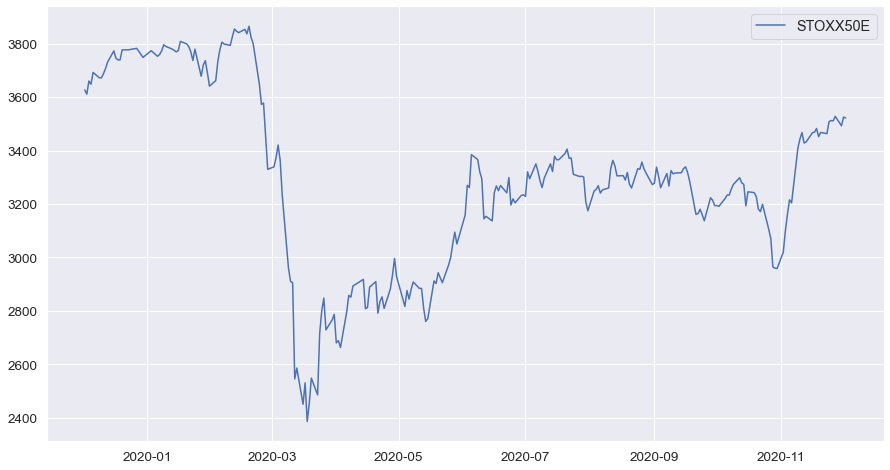

In [262]:
datareader = DataReader()
price = datareader.GetStockData()

### Maximum Likelihood Estimator for callibrating Drift and Volatility of STOXX50E

In [193]:
x_bar, vol = model.MleGBM(price)

MLE for Drift parameter(μ) : -0.0001169688553969635
MLE for Volatility parameter(σ) : 0.020456189051262293


### Simulating Stock Prices as Geometric Brownian Motion with Drift and Volatility using Monte Carlo Simulation

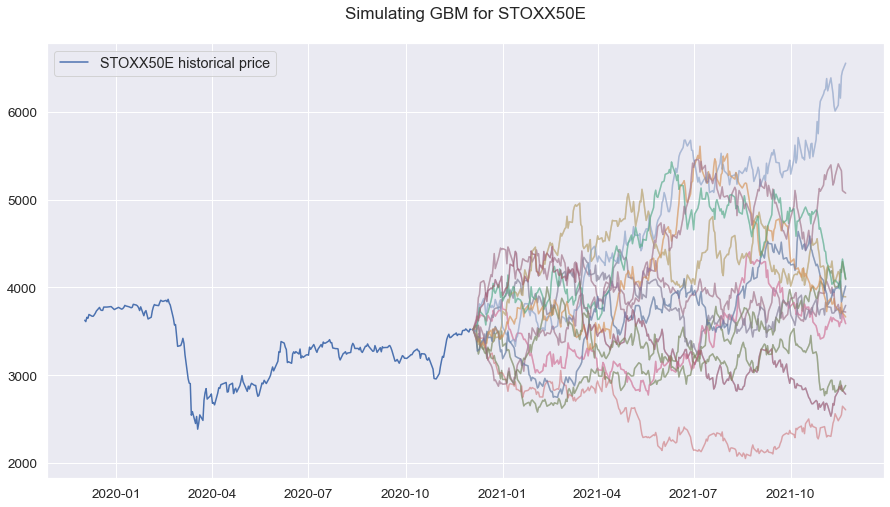

In [196]:
n_simulations = 25

plt.title('Simulating GBM for STOXX50E')
plt.plot(price['Date'], price['Adj Close'], label = "STOXX50E historical price")
for i in range(n_simulations):
    
    seed = np.random.randint(1000)
    price_gbm = model.GBM(seed, price, x_bar, vol)
    plt.plot(price_gbm['Date'], price_gbm['Close'], alpha = 0.45)

plt.legend()
plt.show()

## The Vasicek Model for USD LIBOR rate simulation
dr(t) = k[θ − r(t)]dt + σdW(t)

### Get historical 3-month LIBOR rate

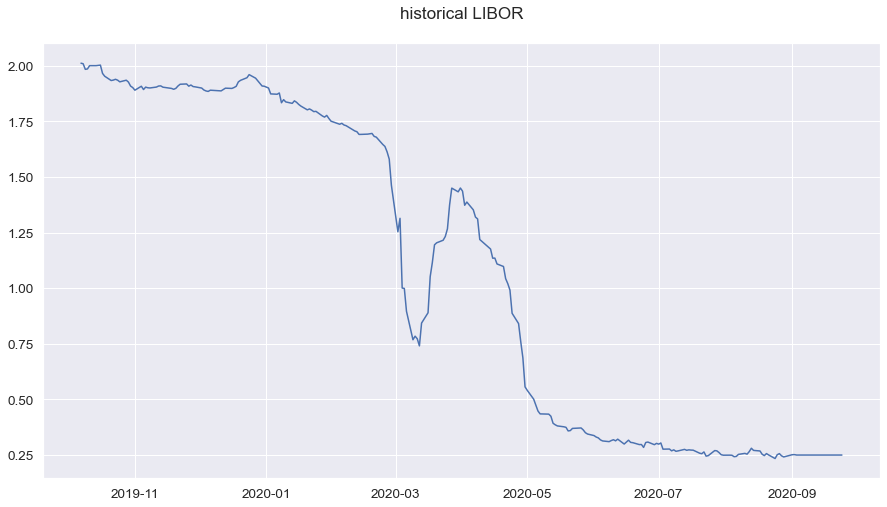

In [263]:
df = datareader.GetLiborData()

### Maximum Likelihood Estimator for callibrating the parameters of Vasicek Model

In [265]:
rn, k, beta, sig = model.MleVasicek(df)
rn, k, beta, sig

(1.1093583337470079,
 0.23251787353619532,
 -1.1258188221046674,
 -0.018260360963076868)

### Simulating USD Libor rate using Vasicek Model

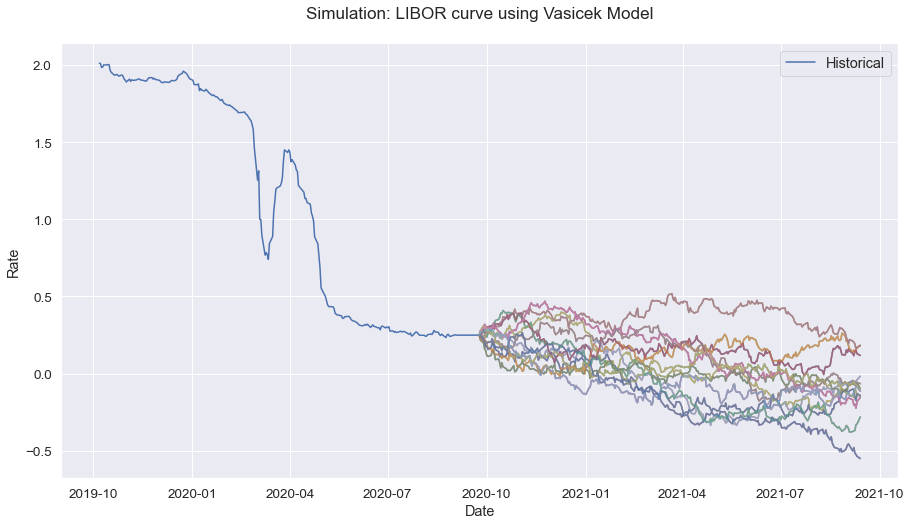

In [277]:
plt.title('Simulation: LIBOR curve using Vasicek Model')
plt.plot(df['Date'], df['3M'], label = "Historical")

for i in range(50):
    
    lib = model.Vasicek(df, df['3M'].iloc[-1], k, beta, sig, 1, 252, seed = np.random.randint(1000))
    plt.plot(lib['Date'], lib['3M'], alpha = 0.55)

plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend()
plt.show()

### Option Pricing 